## Problem statement: 
### To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

# 1. Data Reading/Data Understanding

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Total images for training:',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Total images for test:',image_count_test)

Total images for training: 2239
Total images for test: 118


# 2. Create a dataset

Define some parameters for the loader:
- Created train & validation dataset from the train directory with a batch size of 32 .
- Resized images to 180*180.(10%)

In [4]:
batch_size = 32
img_height = 180
img_width = 180

- Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [8]:

count=[]
for name in class_names:
    count.append(len(list(data_dir_train.glob(name+'/*.jpg'))))

# 3. Dataset visualisation

## checking the count of images for each category of cancer
Class imbalance occurs when the number of instances in one class significantly differs from those in another class within your dataset. This can affect the performance of machine learning models, especially for classification tasks.

# 7. Class distribution
- Image Augmentation (for image data):
- Techniques like rotation, scaling, translation, flipping, and color space augmentation to generate new samples.
### Which class has the least number of samples?
- seborrheic keratosis
### Which classes dominate the data in terms of the proportionate number of samples?
- pigmented benign keratosis

### for Training data

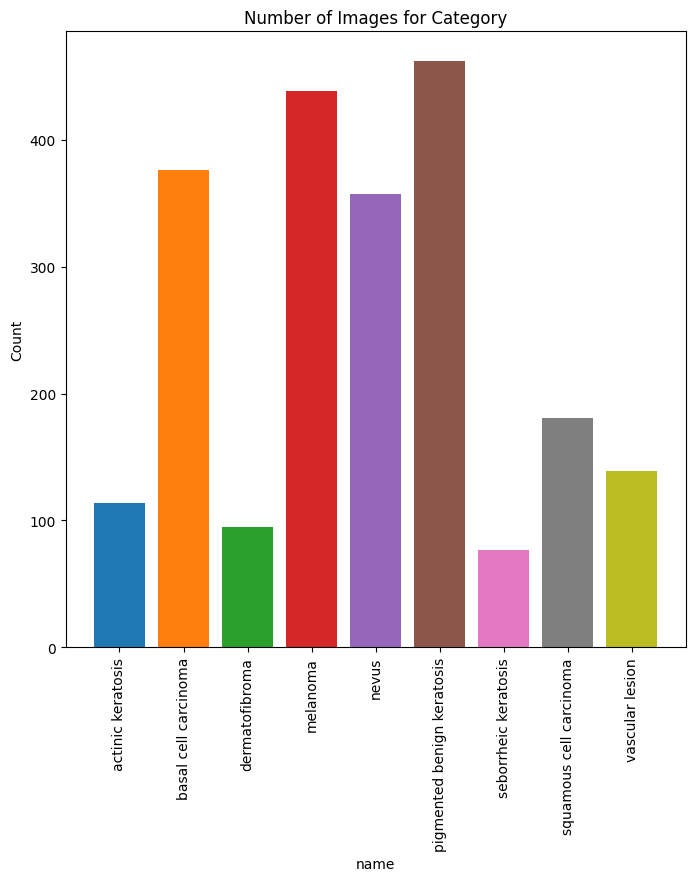

In [9]:
plt.figure(figsize=(8, 8)) 
counts = {}
for name in class_names:
    count=(len(list(data_dir_train.glob(name+'/*.jpg'))))
    counts[name] = count
        # Plotting the counts
    plt.bar(name, counts[name], label=name)
# Adding labels and title
plt.xlabel('name')
plt.ylabel('Count')
plt.title('Number of Images for Category')
plt.xticks(rotation=90)
plt.show()

### For Test Data

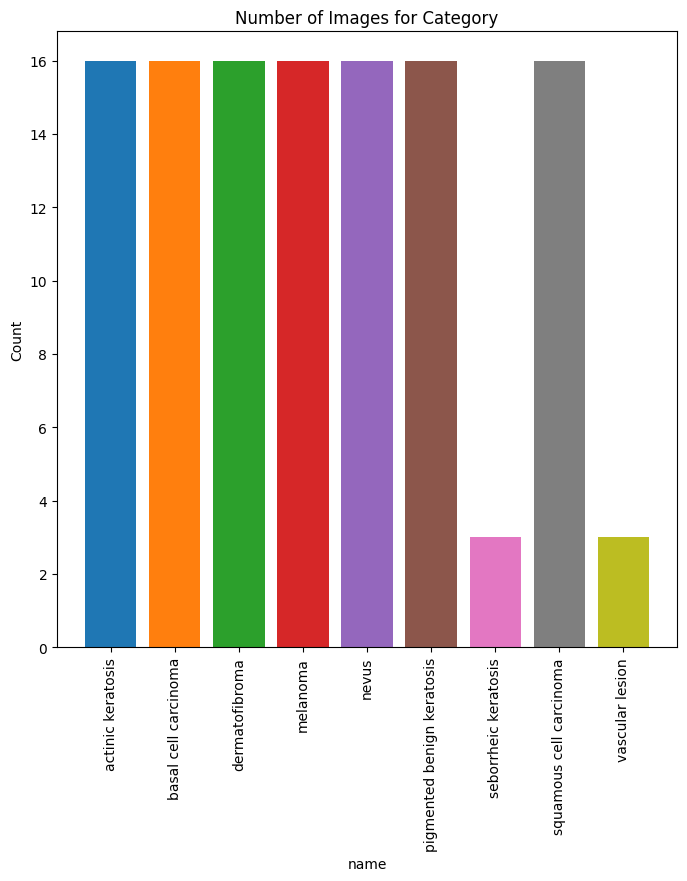

In [10]:
plt.figure(figsize=(8, 8)) 
counts = {}
for name in class_names:
    count=(len(list(data_dir_test.glob(name+'/*.jpg'))))
    counts[name] = count
        # Plotting the counts
    plt.bar(name, counts[name], label=name)
# Adding labels and title
plt.xlabel('name')
plt.ylabel('Count')
plt.title('Number of Images for Category')
plt.xticks(rotation=90)
plt.show()

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-08-10 06:37:16.333745: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


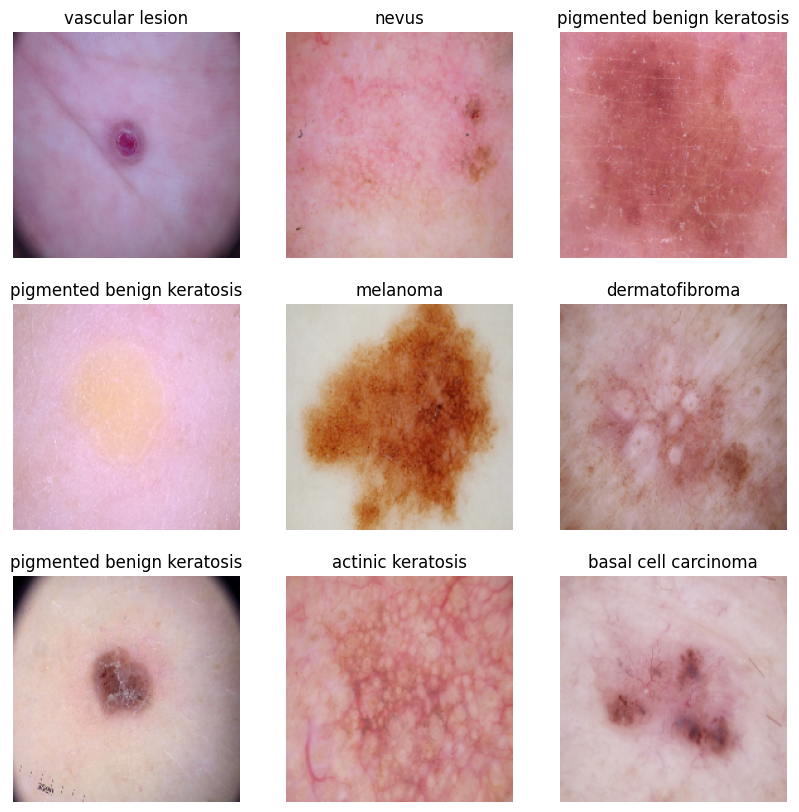

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### your code goes here, you can use training or validation data to visualize

In [12]:
print(type(train_ds))
print(len(train_ds))
print(type(val_ds))
print(len(val_ds))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
56
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
14


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4.Model Building & training
## Create the model
- Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

# Model #1

In [14]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])



### Compile the model
Choose an appropirate optimiser and loss function for model training

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Optimizer='Adam'
- Train: 56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9295 - loss: 0.2000
- Val:   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5924 - loss: 2.3523

In [16]:
### Todo, choose an appropirate optimiser and loss function
#RMSprop. RMSprop is a very effective, but currently unpublished adaptive learning rate method
#Adam. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
model.compile(optimizer='Adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.2139 - loss: 2.0213 - val_accuracy: 0.3110 - val_loss: 1.9720
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.4226 - loss: 1.6569 - val_accuracy: 0.4564 - val_loss: 1.5696
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.5217 - loss: 1.4304 - val_accuracy: 0.5280 - val_loss: 1.4148
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.5436 - loss: 1.2903 - val_accuracy: 0.5436 - val_loss: 1.3852
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.5731 - loss: 1.2179 - val_accuracy: 0.5257 - val_loss: 1.3929
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.6009 - loss: 1.1164 - val_accuracy: 0.5369 - val_loss: 1.3952
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.6450 - loss: 0.9543 - val_accuracy: 0.5593 - val_loss: 1.3557
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.6505 - loss: 0.9411 - val_accuracy: 0

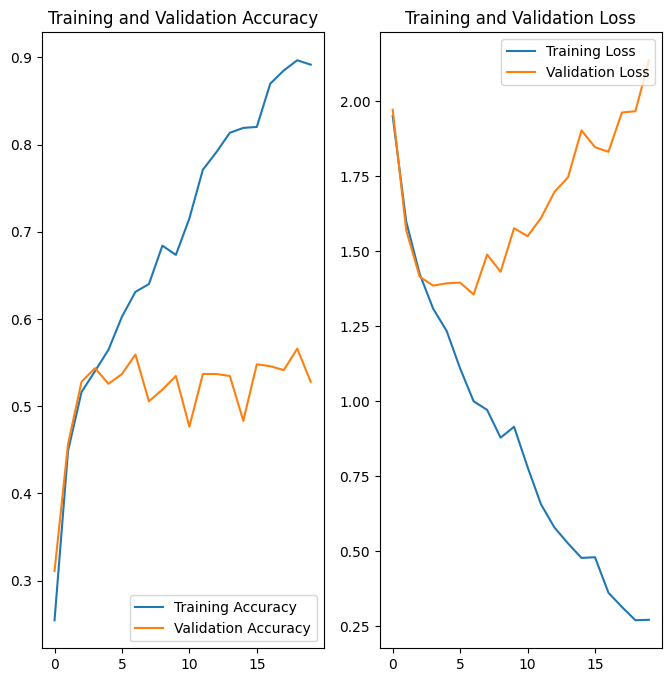

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
model.evaluate(train_ds)
model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9017 - loss: 0.2568
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5547 - loss: 2.0418


[2.1367223262786865, 0.5279642343521118]

# Model #2 - Adam(learning_rate=0.001)

In [20]:
num_classes = 9
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.1825 - loss: 2.2820 - val_accuracy: 0.3244 - val_loss: 1.8298
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.3422 - loss: 1.7788 - val_accuracy: 0.3669 - val_loss: 1.7491
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.4313 - loss: 1.6160 - val_accuracy: 0.4944 - val_loss: 1.4606
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.5302 - loss: 1.4018 - val_accuracy: 0.4966 - val_loss: 1.4552
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.5268 - loss: 1.2978 - val_accuracy: 0.5145 - val_loss: 1.4163
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.5618 - loss: 1.2494 - val_accuracy: 0.5436 - val_loss: 1.3913
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.5871 - loss: 1.1867 - val_accuracy: 0.5123 - val_loss: 1.4501
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.5993 - loss: 1.1373 - val_accuracy

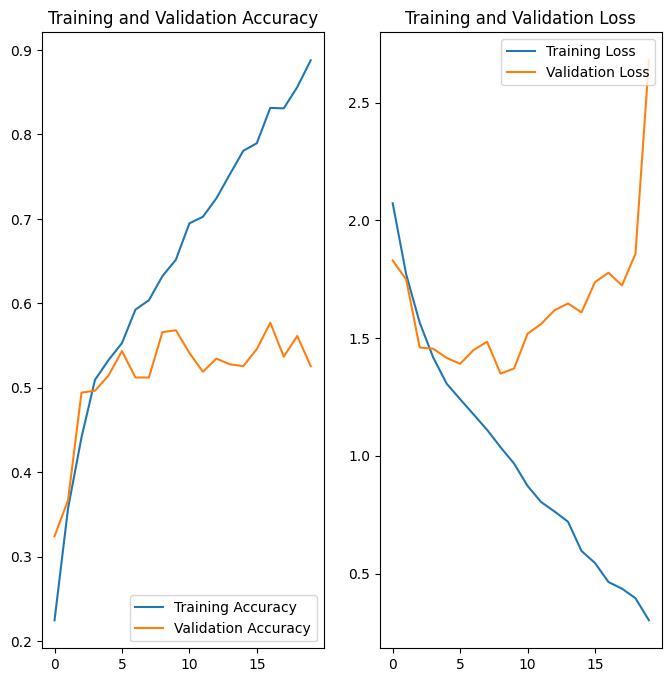

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
model.evaluate(train_ds)
model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8770 - loss: 0.3242
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5402 - loss: 2.6788


[2.6800131797790527, 0.5257270932197571]

### Now lets try Optimizers and compare how they perform

## Optimizer='Adam' with learning rates

# Model #3 Adam(learning_rate=0.00001),

In [23]:
num_classes = 9
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.2031 - loss: 2.0787 - val_accuracy: 0.1902 - val_loss: 2.0347
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.2252 - loss: 2.0090 - val_accuracy: 0.2081 - val_loss: 2.0280
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.2409 - loss: 2.0231 - val_accuracy: 0.2752 - val_loss: 2.0089
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.2570 - loss: 2.0116 - val_accuracy: 0.2371 - val_loss: 1.9964
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.2720 - loss: 1.9853 - val_accuracy: 0.3177 - val_loss: 1.9732
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.3092 - loss: 1.9593 - val_accuracy: 0.2662 - val_loss: 1.9709
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.2781 - loss: 1.9582 - val_accuracy: 0.3020 - val_loss: 1.9407
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.3119 - loss: 1.9276 - val_accuracy: 

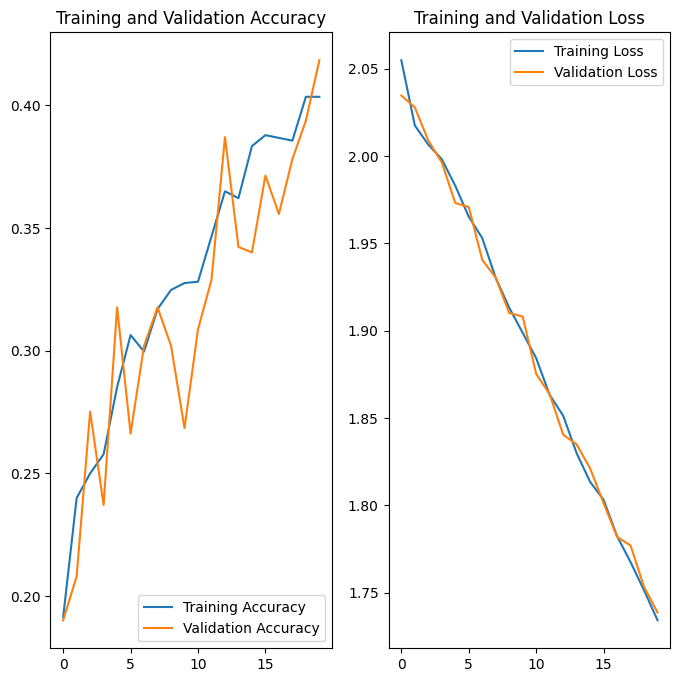

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
model.evaluate(train_ds)
model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4320 - loss: 1.7071
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4782 - loss: 1.6610


[1.7385667562484741, 0.41834452748298645]

## Observation
- Train: 56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.9295 - loss: 0.2000
- Val:   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5924 - loss: 2.3523
### VS - (learning_rate=0.001) - has OverFit
- Train: 56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9351 - loss: 0.1596
- Val:   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5634 - loss: 3.3008
### VS - (learning_rate=0.00001) - this looks to be Robast with no OverFit - *** GOOD So Far ***
- Train: 56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4877 - loss: 0.0773
- Val:   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5456 - loss: 3.6333

## Optimizer='SGD' with learning rate
### Lets look at the model performance with SGD Optimizer for various learning rates.

# Model #4 - optimizer='SGD'

In [26]:
num_classes = 9
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.1868 - loss: 2.0844 - val_accuracy: 0.1946 - val_loss: 2.0353
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.1997 - loss: 2.0256 - val_accuracy: 0.2506 - val_loss: 2.0149
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.2088 - loss: 2.0146 - val_accuracy: 0.2461 - val_loss: 2.0044
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.2407 - loss: 1.9798 - val_accuracy: 0.2707 - val_loss: 1.9852
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.2442 - loss: 1.9960 - val_accuracy: 0.2640 - val_loss: 1.9745
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.2625 - loss: 1.9643 - val_accuracy: 0.2528 - val_loss: 1.9566
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.2896 - loss: 1.9401 - val_accuracy: 0.2953 - val_loss: 1.9203
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - accuracy: 0.2725 - loss: 1.9097 - val_accuracy: 0.

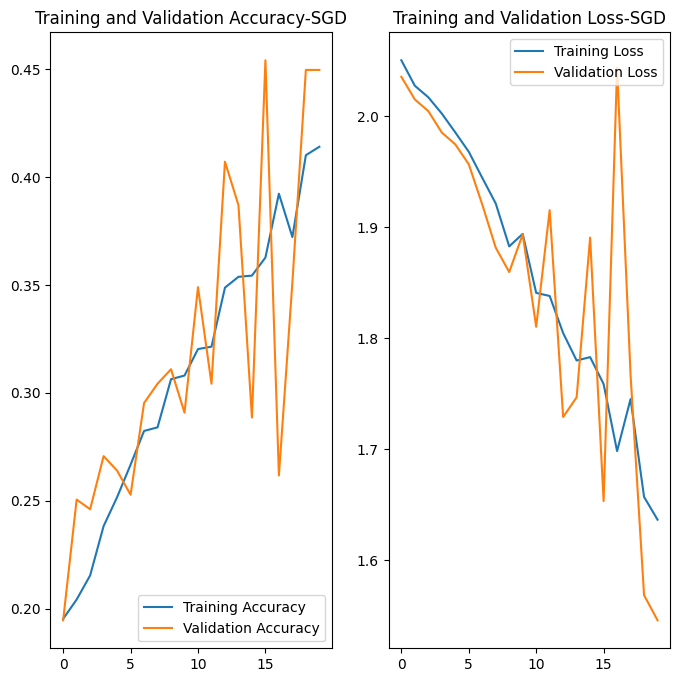

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy-SGD')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss-SGD')
plt.show()

In [28]:
model.evaluate(train_ds)
model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4631 - loss: 1.5359
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.4861 - loss: 1.4796


[1.5458884239196777, 0.449664443731308]

# Model #5 - optimizer='SGD' (learning_rate=0.001)'


In [29]:
num_classes = 9
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - accuracy: 0.0727 - loss: 2.2301 - val_accuracy: 0.0895 - val_loss: 2.2215
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.0814 - loss: 2.2221 - val_accuracy: 0.0917 - val_loss: 2.2152
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.0724 - loss: 2.2177 - val_accuracy: 0.0895 - val_loss: 2.2092
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.0813 - loss: 2.2105 - val_accuracy: 0.1007 - val_loss: 2.2035
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.0854 - loss: 2.2105 - val_accuracy: 0.1141 - val_loss: 2.1981
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.0857 - loss: 2.2036 - val_accuracy: 0.1409 - val_loss: 2.1929
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.1475 - loss: 2.1927 - val_accuracy: 0.1790 - val_loss: 2.1880
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step - accuracy: 0.1695 - loss: 2.1900 - val_accuracy:

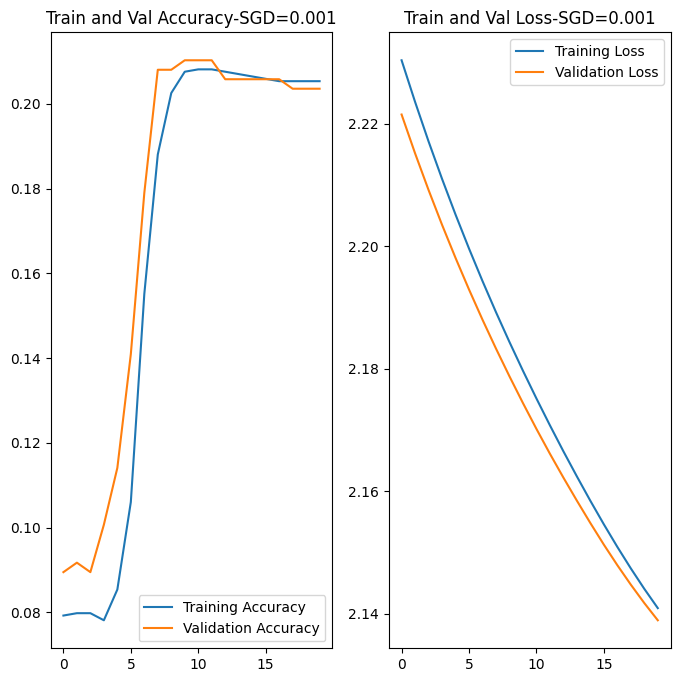

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Val Accuracy-SGD=0.001')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss-SGD=0.001')
plt.show()

In [31]:
model.evaluate(train_ds)
model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1996 - loss: 2.1413
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2038 - loss: 2.1337


[2.1389312744140625, 0.20357941091060638]

# Model #6 - optimizer='SGD' (learning_rate=0.00001)'


In [32]:
num_classes = 9
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
### Todo, choose an appropirate optimiser and loss function
#SGD
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.2010 - loss: 2.1965 - val_accuracy: 0.1834 - val_loss: 2.1957
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.1940 - loss: 2.1967 - val_accuracy: 0.1834 - val_loss: 2.1953
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.1781 - loss: 2.1975 - val_accuracy: 0.1857 - val_loss: 2.1948
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.1870 - loss: 2.1973 - val_accuracy: 0.1879 - val_loss: 2.1944
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 202ms/step - accuracy: 0.1929 - loss: 2.1955 - val_accuracy: 0.1879 - val_loss: 2.1940
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.1962 - loss: 2.1946 - val_accuracy: 0.1879 - val_loss: 2.1935
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.1868 - loss: 2.1957 - val_accuracy: 0.1879 - val_loss: 2.1931
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.1870 - loss: 2.1941 - val_accu

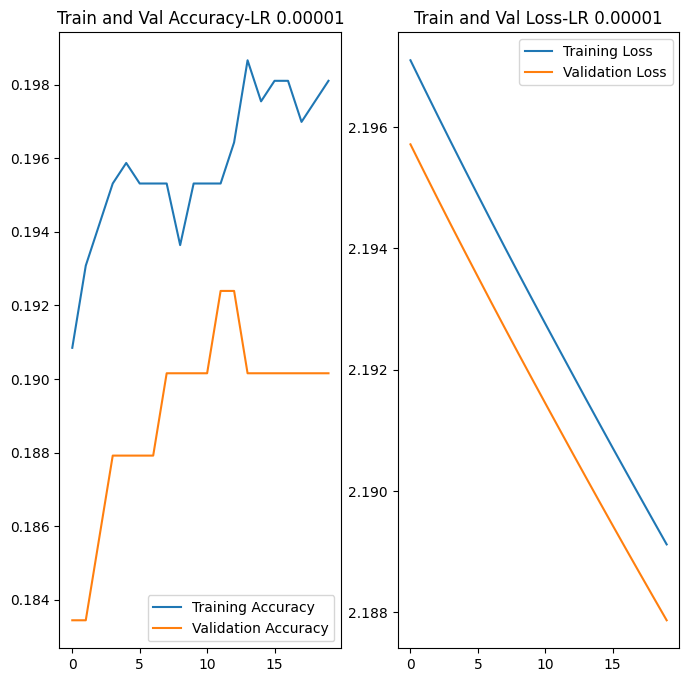

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Val Accuracy-LR 0.00001')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss-LR 0.00001')
plt.show()

In [34]:
model.evaluate(train_ds)
model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.1883 - loss: 2.1898
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.1810 - loss: 2.1871


[2.187868595123291, 0.19015659391880035]

## Observation
- SGD
- Train 56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.4215 - loss: 1.6449
- Val   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4526 - loss: 1.5872
- SGD with LR of 0.00001 
### Not good results for SGD with LR of 0.00001 
- Train 56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.1711 - loss: 2.0733
- Val   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1461 - loss: 2.0794
### Not good results for SGD with LR of 0.001 
- Train 56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4135 - loss: 2.0733
- Val   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4317 - loss: 2.0794

# Adam gave a better result result with 
VS - (learning_rate=0.00001) - this looks to be Robast with no OverFit - *** GOOD So Far ***
Train: 56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.4877 - loss: 0.0773
Val:   14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5456 - loss: 3.6333

### Write your findings here

## Observation: overfitting exists as Train accuracy: 0.8975 Vs Validation accuracy: 0.5722
- with Dropout .2 - Train accuracy:: 0.8301 Validation accuracy: 0.5427 ,  reduced the difference from 32 to 29
- with Dropout .5 - Train accuracy:: 0.7933 Validation accuracy: 0.5511 ,  reduced the difference from 32 to 24
Not a great reduction, and this should not only be the strategy to handle overfitting
## Data Augmentation
Data augmentation artificially increases the size of the training dataset by creating modified versions of images. This helps the model generalize better.
Common Augmentation Techniques:
- Rotation: Rotating images randomly.
- Zooming: Zooming in and out.
- Horizontal/Vertical Flip: Flipping images along axes.
- Shearing: Tilting images.
- Brightness/Contrast Adjustment: Modifying the brightness and contrast.
- Random Cropping: Randomly cropping images.
- choosing Zooming as a strategy

### Experiment features of Flip, Rotation and Zoom works.

In [53]:
data_augmentation = Sequential(
  [
    #layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    #layers.RandomRotation(0.1),
    #layers.RandomZoom(0.2),
    #layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
    #layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  ]
)

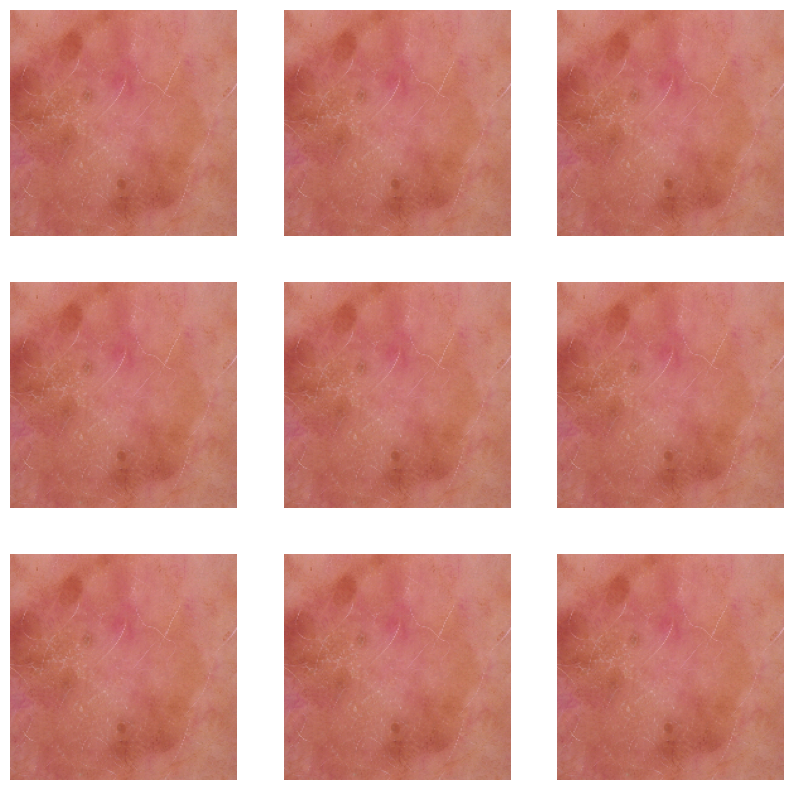

In [54]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Only Zoom 
### Adam
- of 0.1
- Train: 259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.9075 - loss: 0.2411
- Val:   65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8033 - loss: 0.5795

- of 0.2
- Train: 259/259 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9445 - loss: 0.1315
- Val:   65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.8502 - loss: 0.4813
### <font colour='green'>Adam(learning_rate=0.001)</font>
- Train: 259/259 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9298 - loss: 0.1808
- Val:   65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8349 - loss: 0.4823
### <font colour='red'>SGD(learning_rate=0.001)</font>
- Train:  259/259 ━━━━━━━━━━━━━━━━━━━━ 55s 212ms/step - accuracy: 0.1361 - loss: 2.1748
- Val:    65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 220ms/step - accuracy: 0.1404 - loss: 2.1657

### with - Drop layer - SGD(learning_rate=0.001)
- Train: 259/259 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9334 - loss: 0.1878
- Val: 65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.8434 - loss: 0.4736


In [55]:
num_classes = 9
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = Sequential(
  [
    layers.RandomZoom(0.2),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #layers.RandomRotation(0.2),
    layers.RandomCrop(img_height,img_width),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    
  ]
)
data_augmentation.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
#data_augmentation.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001), #did not get good result.
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = data_augmentation.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 506ms/step - accuracy: 0.2074 - loss: 2.0737 - val_accuracy: 0.1969 - val_loss: 1.9969
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 506ms/step - accuracy: 0.2941 - loss: 1.9593 - val_accuracy: 0.2886 - val_loss: 1.9234
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 523ms/step - accuracy: 0.3285 - loss: 1.9103 - val_accuracy: 0.3289 - val_loss: 1.8620
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 511ms/step - accuracy: 0.3759 - loss: 1.8349 - val_accuracy: 0.3714 - val_loss: 1.7866
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 506ms/step - accuracy: 0.3878 - loss: 1.7830 - val_accuracy: 0.4273 - val_loss: 1.7500
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 507ms/step - accuracy: 0.3988 - loss: 1.7480 - val_accuracy: 0.3893 - val_loss: 1.7214
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 512ms/step - accuracy: 0.4095 - loss: 1.7097 - val_accuracy: 0.4362 - val_loss: 1.7105
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 510ms/step - accuracy: 0.4406 - loss: 1.6929 - val_accu

In [57]:
data_augmentation.evaluate(train_ds)
data_augmentation.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.4530 - loss: 1.4801
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4907 - loss: 1.4714


[1.5173312425613403, 0.449664443731308]

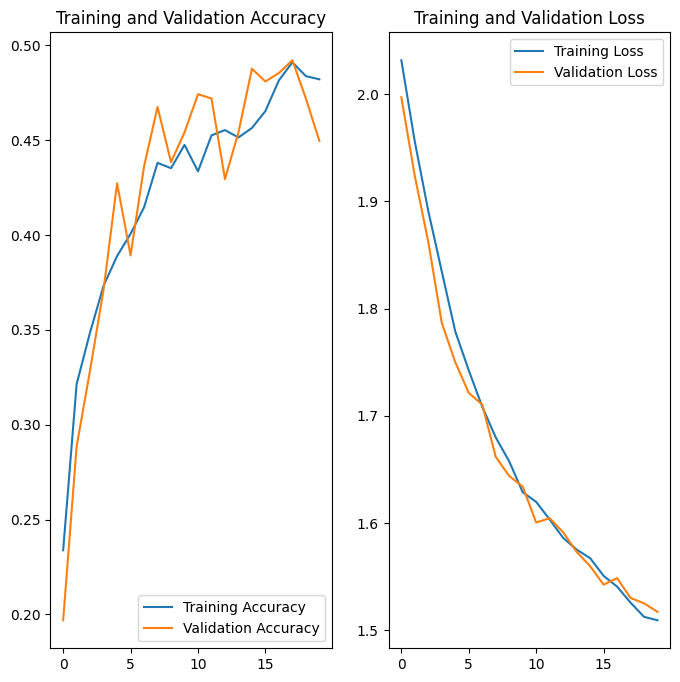

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [132]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

# Create training images generator
#Generate batches of tensor image data with real-time data augmentation.
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )
#https://keras.io/api/preprocessing/image/
#Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 9041 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [56]:
!pip install scipy

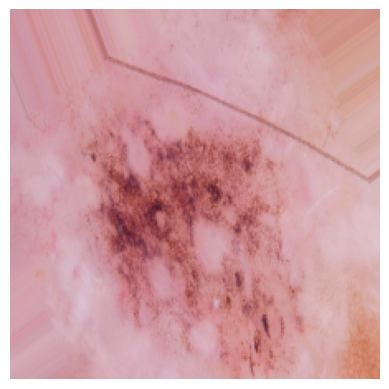

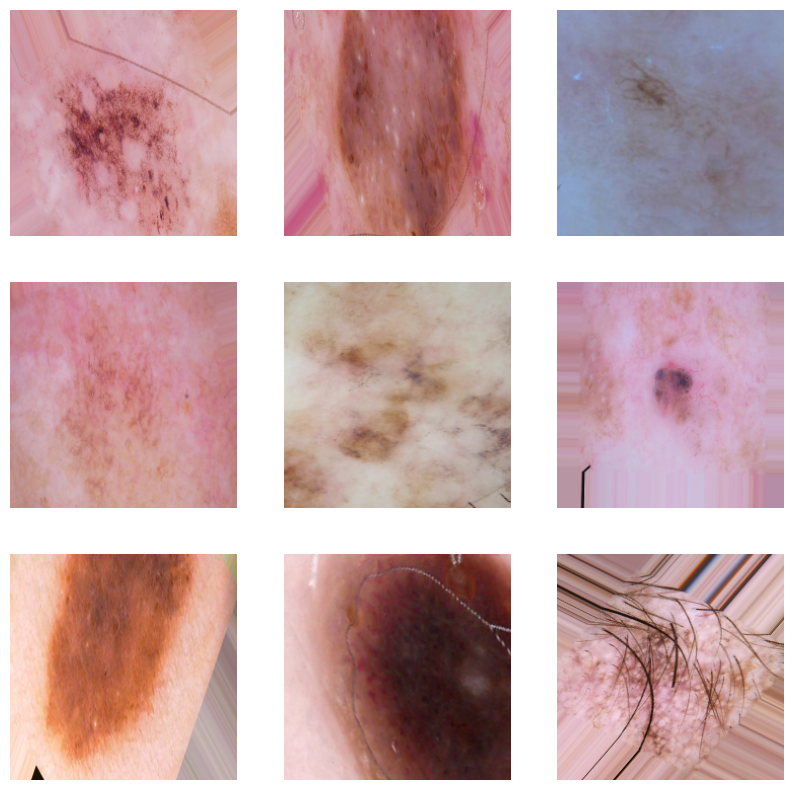

In [83]:
# Fetch a batch of images and labels
images, labels = next(train_data_gen)

# Display the first image in the batch
plt.imshow(images[0])
plt.axis('off')  # Hide axes
plt.show()

# Display a few more images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


### Findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

####  The distribution of classes in the training dataset.
####  From above charts we know that this dataset has class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [84]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [85]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path           Label
0     /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...        melanoma
1     /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...        melanoma
2     /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...        melanoma
3     /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...        melanoma
4     /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...        melanoma
...                                                 ...             ...
2234  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  dermatofibroma
2235  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  dermatofibroma
2236  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  dermatofibroma
2237  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  dermatofibroma
2238  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  dermatofibroma

[2239 rows x 2 columns]

Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=4, n=357 (15.945%)
Class=1, n=376 (16.793%)
Class=0, n=114 (5.092%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)
Class=6, n=77 (3.439%)
Class=2, n=95 (4.243%)


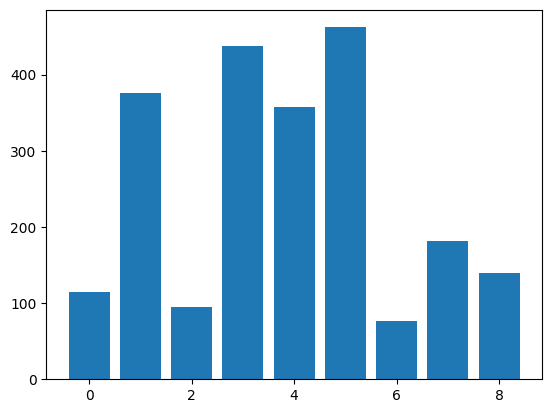

In [86]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### Write your findings here:
#### - Which class has the least number of samples?
- seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis

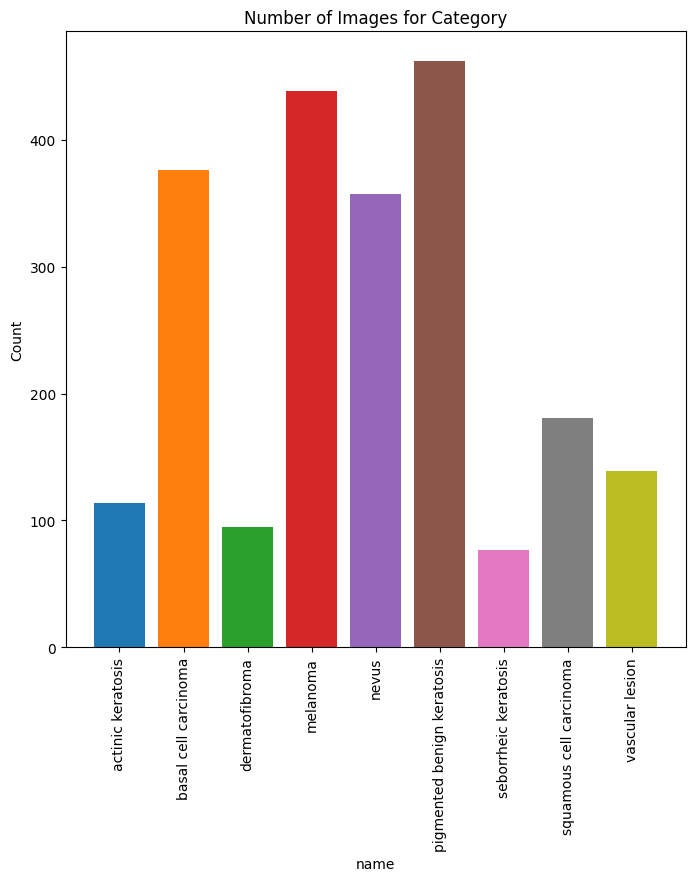

In [87]:
plt.figure(figsize=(8, 8)) 
counts = {}
for name in class_names:
    count=(len(list(data_dir_train.glob(name+'/*.jpg'))))
    counts[name] = count
        # Plotting the counts
    plt.bar(name, counts[name], label=name)
# Adding labels and title
plt.xlabel('name')
plt.ylabel('Count')
plt.title('Number of Images for Category')
plt.xticks(rotation=90)
plt.show()

#### Rectify the class imbalance
####  using a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to adding more samples across all classes so that none of the classes have very few samples.

### Results:
- Train: 259/259 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.9175 - loss: 0.1850
- Val:   65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.7754 - loss: 0.9748

- Train: 259/259 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9288 - loss: 0.1640
- Val:   65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7756 - loss: 1.0163

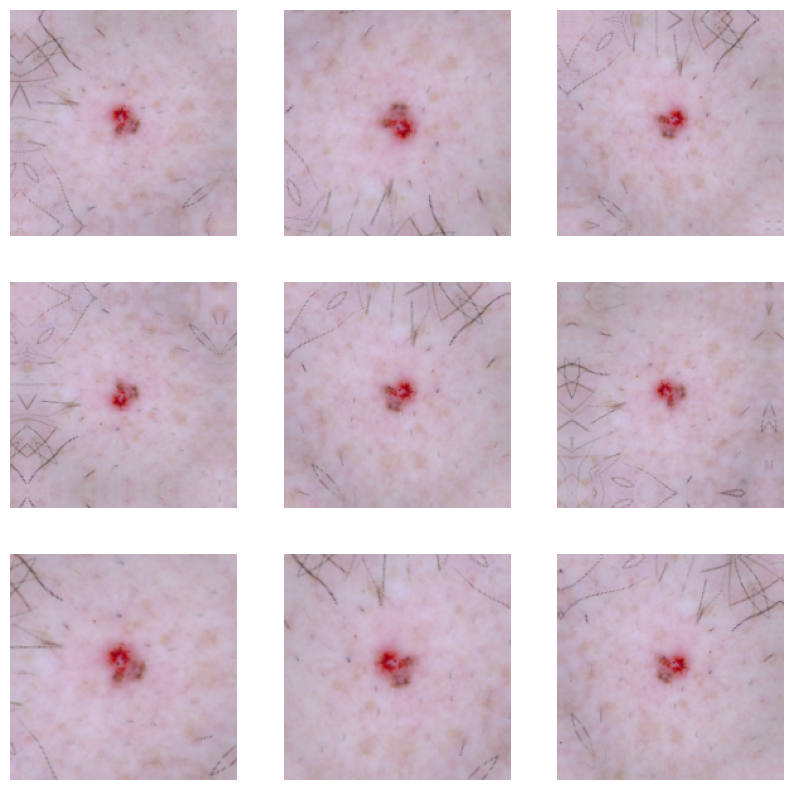

In [64]:
from tensorflow.keras import  regularizers
input_shape = (180, 180, 3)
num_classes = 9

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    
model = Sequential([
layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Resizing(img_height, img_width),

data_augmentation,
layers.Conv2D(32, (3, 3), padding='same',input_shape=input_shape),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(32, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Conv2D(64, (3, 3), padding='same'),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(64, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Conv2D(128, (3, 3), padding='same'),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(128, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Conv2D(256, (3, 3), padding='same'),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(256, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Flatten(),
layers.Dense(512,kernel_regularizer=regularizers.l2(0.01)),
layers.Activation('relu'),
layers.Dropout(0.5),
layers.Dense(num_classes),
layers.Activation('softmax')
])

In [65]:
## Your code goes here
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [66]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.2335 - loss: 25.6542 - val_accuracy: 0.1790 - val_loss: 18.1702
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.2780 - loss: 15.7152 - val_accuracy: 0.0537 - val_loss: 22.7028
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.3236 - loss: 11.4095 - val_accuracy: 0.1946 - val_loss: 13.5168
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.3552 - loss: 8.7006 - val_accuracy: 0.1812 - val_loss: 8.3852
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.3613 - loss: 6.6012 - val_accuracy: 0.1499 - val_loss: 6.9215
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.3927 - loss: 5.1590 - val_accuracy: 0.2282 - val_loss: 7.6383
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.4332 - loss: 4.1386 - val_accuracy: 0.1275 - val_loss: 5.2379
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.3987 - loss: 3.6976 - val_accuracy: 0.24

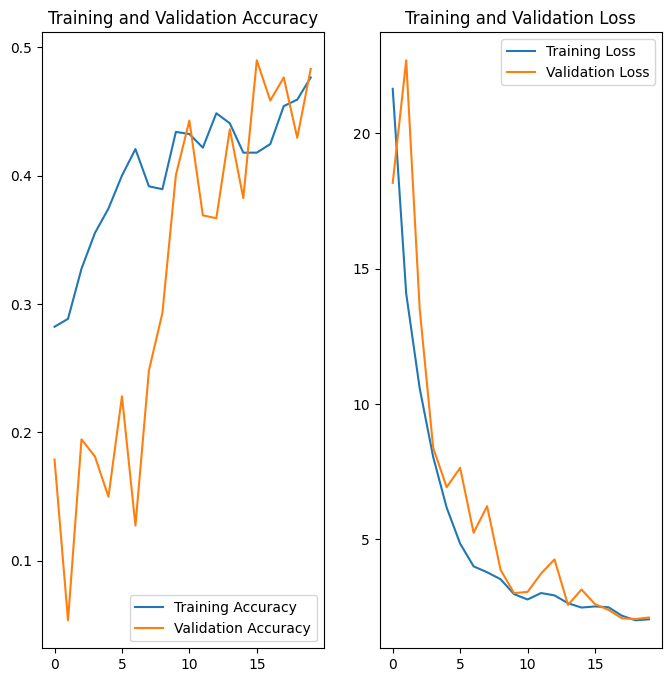

In [67]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [68]:
model.evaluate(train_ds)
model.evaluate(val_ds)

56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.5119 - loss: 1.9219
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 363ms/step - accuracy: 0.4959 - loss: 2.1800


[2.1058552265167236, 0.48322147130966187]

## 8.Handling class imbalances 
- using Augmentor

In [69]:
!pip install Augmentor

# copied images from Colab as Augmentor did not work on my local env.

In [76]:
from glob import glob

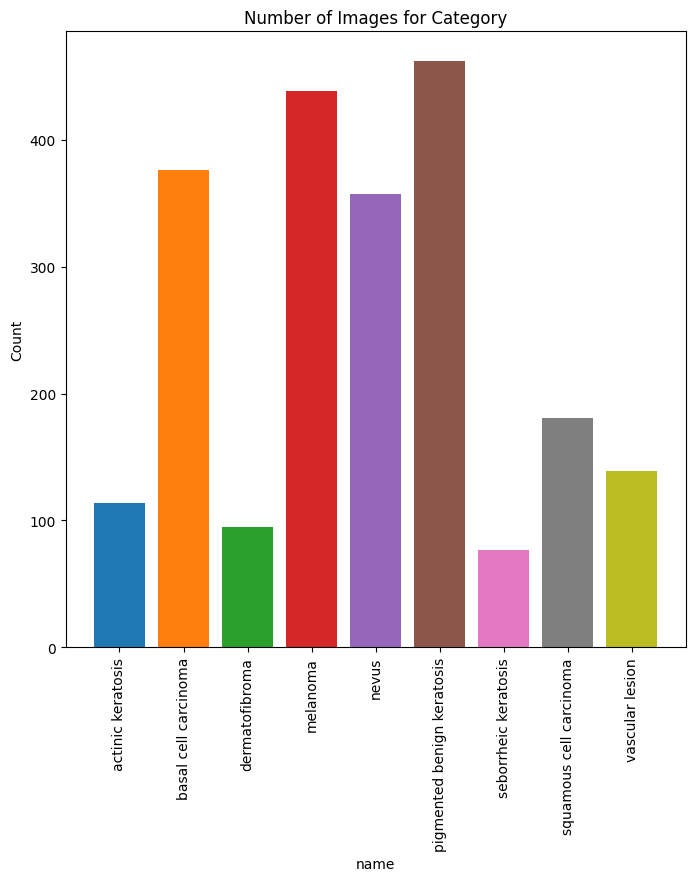

In [70]:
plt.figure(figsize=(8, 8)) 
counts = {}
for name in class_names:
    count=(len(list(data_dir_train.glob(name+'/*.jpg'))))
    counts[name] = count
        # Plotting the counts
    plt.bar(name, counts[name], label=name)
# Adding labels and title
plt.xlabel('name')
plt.ylabel('Count')
plt.title('Number of Images for Category')
plt.xticks(rotation=90)
plt.show()

In [72]:
#https://github.com/mdbloice/Augmentor

datapath = '/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
import Augmentor

for cancer_class in ['actinic keratosis',  'dermatofibroma',  'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']:
  p = Augmentor.Pipeline(os.path.join(datapath, cancer_class))
  #Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
  p.sample(275)
  p.process()


Initialised with 114 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17C1C5910>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1780E5750>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BFF1690>: 100%|█|
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1


Initialised with 77 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1658887D0>: 100%|█
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x309085B10>: 100%|█


Initialised with 181 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17C1DC750>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1781F9810>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x178102810>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17810FF50>: 100%|█|


In [104]:
#['actinic keratosis', 'dermatofibroma',  'seborrheic keratosis', 'squamous cell carcinoma'] - 200
for cancer_class in ['actinic keratosis', 'dermatofibroma',  'seborrheic keratosis', 'squamous cell carcinoma']:
  p = Augmentor.Pipeline(os.path.join(datapath, cancer_class))
  #Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
  p.sample(200)
  p.process()

Initialised with 114 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BFCDF50>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16582CA90>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x165850450>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1657DF910>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17FF38790>: 100%|█
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 181 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17C179B50>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17FFE2E50>: 100%|█|


In [114]:
#['actinic keratosis', 'dermatofibroma', 'nevus' , 'vascular lesion'] - 100
for cancer_class in ['actinic keratosis', 'dermatofibroma', 'nevus' , 'vascular lesion']:
  p = Augmentor.Pipeline(os.path.join(datapath, cancer_class))
  #Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
  p.sample(100)
  p.process()

Initialised with 114 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x309737210>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3098A1250>: 100%|█|


Initialised with 95 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x12C99A710>: 100%|█|


Initialised with 357 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x16587B490>: 100%|
Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x1656D7110>: 100%|


Initialised with 139 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x165739990>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16578BD10>: 100%|█|


In [93]:
for cancer_class in [ 'basal cell carcinoma',  'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis',  'vascular lesion']:
  p = Augmentor.Pipeline(os.path.join(datapath, cancer_class))
  #Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
  p.sample(100)
  p.process()

Initialised with 376 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x165893390>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17816AF90>: 100%|█|


Initialised with 438 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x1781C4410>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x17C144C90>: 100%|█


Initialised with 357 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=724x542 at 0x1781C5B90>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x3097F5D90>: 100%|


Initialised with 462 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17B99F410>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17C19ED50>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x391B69890>: 100%|█
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16586E690>: 100%|█


Initialised with 139 image(s) found.
Output directory set to /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17FF90790>: 100%|█|
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x17BF64F10>: 100%|█|


In [115]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

6802


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Lets see the distribution of augmented data after adding new images to the original training data.

In [116]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001106.jpg_b3e2c043-59d1-4688-a403-d73fec4c3928.jpg',
 '/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0001148.jpg_6f1714c6-2d45-4e73-a4e0-f191a93d88d1.jpg',
 '/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009993.jpg_27f8f5e2-df82-4189-ac10-859266fdaf51.jpg',
 '/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010171.jpg_a68f809a-4ed1-4cf1-be44-b48abf384ea6.jpg',
 '/Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010925.jpg_4e644c71

In [117]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [118]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [119]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [120]:
new_df['Label'].value_counts()

Label
nevus                         1271
actinic keratosis             1031
vascular lesion               1031
pigmented benign keratosis    1024
squamous cell carcinoma       1018
melanoma                       976
dermatofibroma                 955
seborrheic keratosis           883
basal cell carcinoma           852
Name: count, dtype: int64

So, now we have added 275 + 100 images to the classes with low image counts to maintain some class balance. We can add more images as we want to improve training process.

In [121]:
new_df.head()

Path     Label
0  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  melanoma
1  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  melanoma
2  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  melanoma
3  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  melanoma
4  /Users/narayanaisanaka/UpGrad/2024/CNN/MEL/Ski...  melanoma

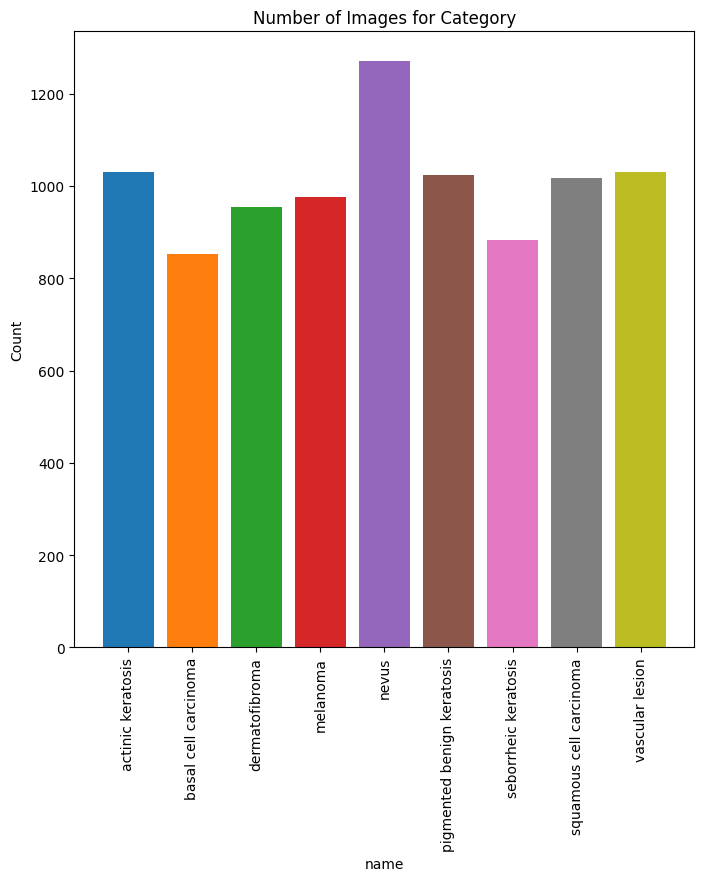

In [125]:
plt.figure(figsize=(8, 8)) 
counts = {}

for name in class_names:
    label_counts = new_df['Label'].value_counts()
    plt.bar(name, label_counts[name], label=name)
# Adding labels and title
plt.xlabel('name')
plt.ylabel('Count')
plt.title('Number of Images for Category')
plt.xticks(rotation=90)
plt.show()



#### **Todo**: Train the model on the data created using Augmentor

In [129]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [130]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9041 files belonging to 9 classes.
Using 7233 files for training.


#### **Todo:** Create a validation dataset

In [131]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9041 files belonging to 9 classes.
Using 1808 files for validation.


In [ ]:
num_classes = 9
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)
#after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
model = Sequential(
  [
    data_augmentation,
    #layers.RandomZoom(0.2),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    #layers.RandomRotation(0.2),
    #layers.RandomCrop(img_height,img_width),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    
  ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - accuracy: 0.1363 - loss: 2.1907 - val_accuracy: 0.2019 - val_loss: 2.1451
Epoch 2/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - accuracy: 0.2018 - loss: 2.1309 - val_accuracy: 0.2616 - val_loss: 2.0680
Epoch 3/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 215ms/step - accuracy: 0.2309 - loss: 2.0602 - val_accuracy: 0.2577 - val_loss: 2.0041
Epoch 4/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 215ms/step - accuracy: 0.2557 - loss: 1.9881 - val_accuracy: 0.2837 - val_loss: 1.9353
Epoch 5/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 217ms/step - accuracy: 0.2852 - loss: 1.9240 - val_accuracy: 0.3180 - val_loss: 1.8595
Epoch 6/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - accuracy: 0.3052 - loss: 1.8606 - val_accuracy: 0.3075 - val_loss: 1.8251
Epoch 7/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 216ms/step - accuracy: 0.3265 - loss: 1.8012 - val_accuracy: 0.3241 - val_loss: 1.7640
Epoch 8/20
227/227 ━━━━━━━━━━━━━━━━━━━━ 49s 217ms/step - accuracy: 0.3175 - loss: 1

#### **Todo:**  Visualize the model results

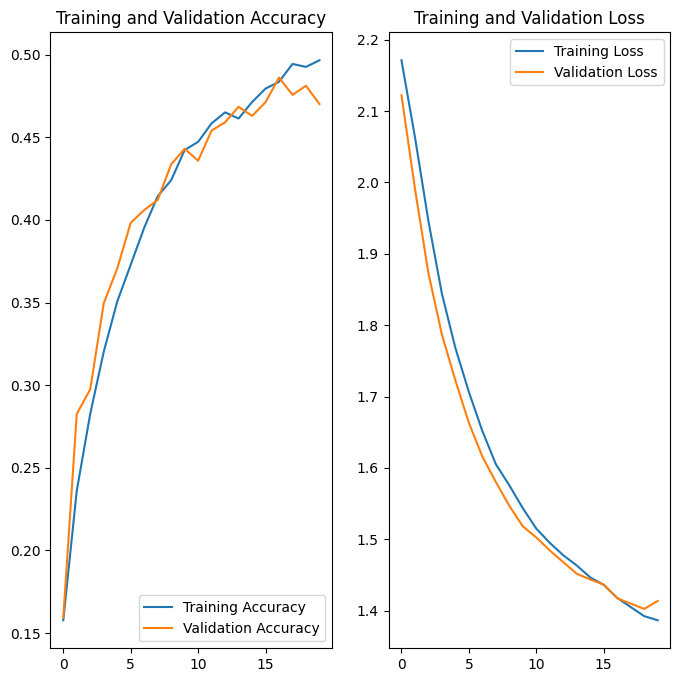

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [139]:
model.evaluate(train_ds)
model.evaluate(val_ds)

ValueError: You must call `compile()` before using the model.

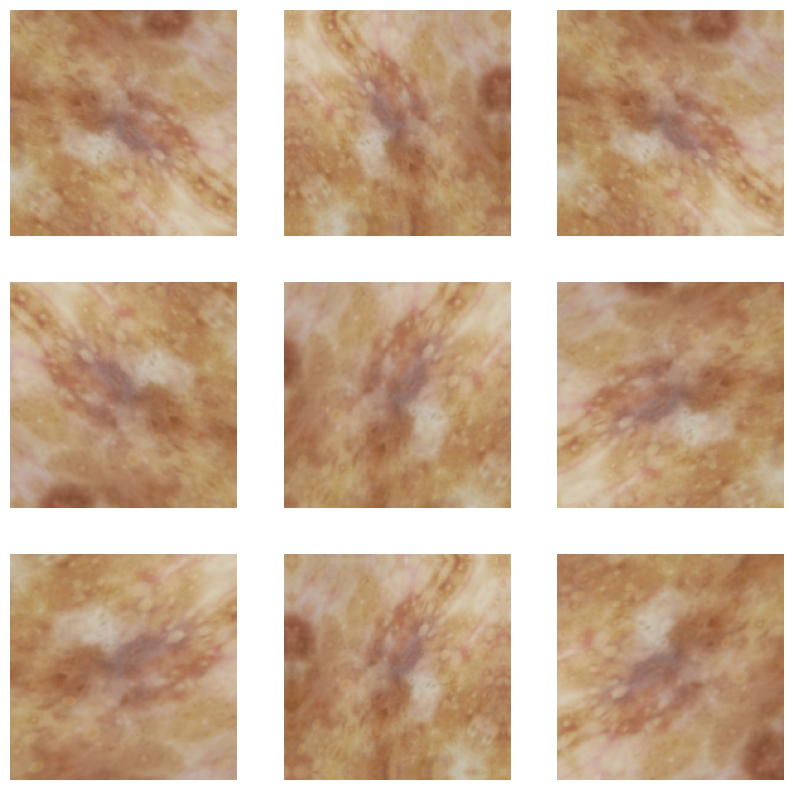

In [137]:
from tensorflow.keras import  regularizers
input_shape = (180, 180, 3)
num_classes = 9

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)
 
model = Sequential([
layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
layers.Resizing(img_height, img_width),

data_augmentation,
layers.Conv2D(32, (3, 3), padding='same',input_shape=input_shape),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(32, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Conv2D(64, (3, 3), padding='same'),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(64, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Conv2D(128, (3, 3), padding='same'),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(128, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Conv2D(256, (3, 3), padding='same'),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.Conv2D(256, (3, 3)),
layers.Activation('relu'),
layers.BatchNormalization(),
layers.MaxPooling2D(pool_size=(2, 2)),
layers.Dropout(0.25),

layers.Flatten(),
layers.Dense(512,kernel_regularizer=regularizers.l2(0.01)),
layers.Activation('relu'),
layers.Dropout(0.5),
layers.Dense(num_classes),
layers.Activation('softmax')
])

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()